In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import glob
import os
import re
from collections import deque

# --- 1. NORMALIZAÇÃO COMPLETA (Corrige nomes cortados) ---
def normalizar_times(nome):
    nome = str(nome).strip()
    # Substituições para nomes cortados que vimos no seu LOG
    substituicoes = {
        'Internaciona': 'Internacional',
        'Sampaio Corr': 'Sampaio Corrêa',
        'Atletico-GO': 'Atlético-GO',
        'Atlético-MG': 'Atlético-MG',
        'Athletico-PR': 'Atlético-PR',
        'Athletico Paranaense': 'Atlético-PR',
        'Ceará SC': 'Ceará',
        'Sport Recife': 'Sport',
        'Vasco da Gama': 'Vasco',
        'América Mineiro': 'América-MG',
        'Red Bull Bragantino': 'Bragantino',
        'Grêmio Novorizontino': 'Novorizontino',
        'Operário-PR': 'Operário Ferroviário'
    }
    # Se o nome começar com uma das chaves, ele troca pelo valor
    for curto, completo in substituicoes.items():
        if nome.startswith(curto):
            return completo
    return nome

def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split('([0-9]+)', s)]

# --- 2. MOTOR DE FEATURES COM COPA E H2H RESTAURADOS ---
def gerar_features_completas(df_jogos, df_times, df_historico, df_copas_total):
    COL_M, COL_V = 'Time da Casa', 'Time Visitante'
    df_jogos = df_jogos.copy()
    df_jogos[COL_M] = df_jogos[COL_M].apply(normalizar_times)
    df_jogos[COL_V] = df_jogos[COL_V].apply(normalizar_times)
    
    # Formato de data fixo para matar o UserWarning
    df_jogos['Data_DT'] = pd.to_datetime(df_jogos['Data'], dayfirst=True, errors='coerce', format='%d/%m/%y')
    
    df_hist = df_historico.copy()
    df_hist[COL_M] = df_hist[COL_M].apply(normalizar_times)
    df_hist[COL_V] = df_hist[COL_V].apply(normalizar_times)
    df_hist['Data_DT'] = pd.to_datetime(df_hist['Data'], dayfirst=True, errors='coerce', format='%d/%m/%y')

    def extrair_gols(placar):
        try:
            p = str(placar).replace('–', '-').split('-')
            return int(p[0]), int(p[1])
        except: return 0, 0

    df_jogos['Gols_M'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[0])
    df_jogos['Gols_V'] = df_jogos['Placar'].apply(lambda p: extrair_gols(p)[1])
    
    media_gols_liga = df_jogos['Gols_M'].mean() if not df_jogos.empty else 1.2
    
    # Ajuste na região (normaliza antes do map)
    df_times_norm = df_times.copy()
    df_times_norm['time'] = df_times_norm['time'].apply(normalizar_times)
    mapa_regiao = df_times_norm.set_index('time')['região'].to_dict()
    
    ut = pd.concat([df_jogos[COL_M], df_jogos[COL_V]]).unique()
    
    stats = {t: {
        'pts': 0, 'j': 0, 'v': 0, 'sg_c': 0, 'sg_f': 0,
        'gm_c': 0, 'gs_c': 0, 'j_c': 0, 'gm_f': 0, 'gs_f': 0, 'j_f': 0,
        'u5_sg_c': deque(maxlen=5), 'u5_sg_f': deque(maxlen=5), 'u5_res': deque(maxlen=5)
    } for t in ut}
    
    listas = {k: [] for k in [
        'Posicao_Mandante', 'Posicao_Visitante', 'Media_GM_Casa', 'Media_GS_Casa',
        'Media_GM_Fora', 'Media_GS_Fora', 'Saldo_Gols_Casa_Mandante', 'Saldo_Gols_Fora_Visitante',
        'Saldo_Ultimos_5_Casa_Mandante', 'Saldo_Ultimos_5_Fora_Visitante',
        'Sequencia_5_Mandante', 'Sequencia_5_Visitante', 'Proxima_Copa_Mandante', 'Proxima_Copa_Visitante',
        'Forca_Atk_M', 'Forca_Def_V', 'Sinal_Dominio', 'Momentum_M', 'Momentum_V',
        'Desespero_Mandante', 'Desespero_Visitante', 'Delta_Desespero',
        'Soberba_Mandante', 'Soberba_Visitante', 'Delta_Soberba',
        'H2H_Vits_M', 'H2H_Empates', 'H2H_Vits_V'
    ]}

    # Preparar df_copas para busca rápida
    df_copas_norm = df_copas_total.copy()
    df_copas_norm[COL_M] = df_copas_norm[COL_M].apply(normalizar_times)
    df_copas_norm[COL_V] = df_copas_norm[COL_V].apply(normalizar_times)
    df_copas_norm['Data_DT'] = pd.to_datetime(df_copas_norm['Data'], dayfirst=True, errors='coerce', format='%d/%m/%y')

    for rd in range(1, 39):
        df_class = pd.DataFrame.from_dict(stats, orient='index')
        df_class['sg_t'] = df_class['sg_c'] + df_class['sg_f']
        df_class = df_class.sort_values(by=['pts', 'v', 'sg_t'], ascending=False)
        df_class['pos'] = range(1, len(df_class) + 1)
        mapa_pos = df_class['pos'].to_dict()
        
        jogos_rd = df_jogos[df_jogos['Rodada'] == rd]
        for _, jogo in jogos_rd.iterrows():
            m, v, dt = jogo[COL_M], jogo[COL_V], jogo['Data_DT']
            sm, sv = stats[m], stats[v]
            pm, pv = mapa_pos.get(m, 21), mapa_pos.get(v, 21)

            # --- SENSOR COPA (RESTAURADO) ---
            def check_copa(time, data):
                prox = df_copas_norm[((df_copas_norm[COL_M] == time) | (df_copas_norm[COL_V] == time)) & (df_copas_norm['Data_DT'] > data)]
                if not prox.empty:
                    dias = (prox['Data_DT'].min() - data).days
                    return 1 if dias <= 7 else 0
                return 0
            listas['Proxima_Copa_Mandante'].append(check_copa(m, dt))
            listas['Proxima_Copa_Visitante'].append(check_copa(v, dt))

            # --- SENSOR H2H ---
            h2h = df_hist[(((df_hist[COL_M] == m) & (df_hist[COL_V] == v)) |
                           ((df_hist[COL_M] == v) & (df_hist[COL_V] == m))) & (df_hist['Data_DT'] < dt)]
            v_m, emp, v_v = 0, 0, 0
            if not h2h.empty:
                for _, ph in h2h.iterrows():
                    g1, g2 = extrair_gols(ph['Placar'])
                    if ph[COL_M] == m:
                        if g1 > g2: v_m += 1
                        elif g2 > g1: v_v += 1
                        else: emp += 1
                    else:
                        if g2 > g1: v_m += 1
                        elif g1 > g2: v_v += 1
                        else: emp += 1
                v_m, emp, v_v = v_m/len(h2h), emp/len(h2h), v_v/len(h2h)

            listas['H2H_Vits_M'].append(v_m); listas['H2H_Empates'].append(emp); listas['H2H_Vits_V'].append(v_v)
            listas['Posicao_Mandante'].append(pm); listas['Posicao_Visitante'].append(pv)
            listas['Media_GM_Casa'].append(sm['gm_c']/sm['j_c'] if sm['j_c']>0 else 0)
            listas['Media_GS_Casa'].append(sm['gs_c']/sm['j_c'] if sm['j_c']>0 else 0)
            listas['Media_GM_Fora'].append(sv['gm_f']/sv['j_f'] if sv['j_f']>0 else 0)
            listas['Media_GS_Fora'].append(sv['gs_f']/sv['j_f'] if sv['j_f']>0 else 0)
            listas['Saldo_Gols_Casa_Mandante'].append(sm['sg_c'])
            listas['Saldo_Gols_Fora_Visitante'].append(sv['sg_f'])
            listas['Saldo_Ultimos_5_Casa_Mandante'].append(sum(sm['u5_sg_c']))
            listas['Saldo_Ultimos_5_Fora_Visitante'].append(sum(sv['u5_sg_f']))
            listas['Sequencia_5_Mandante'].append(''.join(sm['u5_res']) or '-')
            listas['Sequencia_5_Visitante'].append(''.join(sv['u5_res']) or '-')

            # Força e Momentum
            f_atk = (sm['gm_c']/sm['j_c'] if sm['j_c']>0 else 1.0) / media_gols_liga
            f_def = (sv['gs_f']/sv['j_f'] if sv['j_f']>0 else 1.0) / media_gols_liga
            listas['Forca_Atk_M'].append(f_atk); listas['Forca_Def_V'].append(f_def); listas['Sinal_Dominio'].append(f_atk * f_def)
            
            def calc_mom(dq):
                vls = [{'V':3,'E':1,'D':0}.get(x,0) for x in dq]
                return sum(v * (i+1) for i, v in enumerate(vls))/sum(range(1,len(vls)+1)) if vls else 0
            listas['Momentum_M'].append(calc_mom(sm['u5_res'])); listas['Momentum_V'].append(calc_mom(sv['u5_res']))

            dm = (1.2 if pm >= 17 else (1.0 if pm <= 3 else 0.5)) * (rd/38) if rd > 10 else 0
            dv = (1.2 if pv >= 17 else (1.0 if pv <= 3 else 0.5)) * (rd/38) if rd > 10 else 0
            listas['Desespero_Mandante'].append(dm); listas['Desespero_Visitante'].append(dv); listas['Delta_Desespero'].append(dm - dv)
            sob_m = ((pv - pm)/20)**2 * (rd/38) if pv > pm else 0
            sob_v = ((pm - pv)/20)**2 * (rd/38) if pm > pv else 0
            listas['Soberba_Mandante'].append(sob_m); listas['Soberba_Visitante'].append(sob_v); listas['Delta_Soberba'].append(sob_m - sob_v)

            # ATUALIZAÇÃO
            gm, gv = jogo['Gols_M'], jogo['Gols_V']
            res_m, res_v = ('V','D') if gm > gv else (('D','V') if gv > gm else ('E','E'))
            sm['u5_res'].append(res_m); sv['u5_res'].append(res_v)
            sm['u5_sg_c'].append(gm-gv); sv['u5_sg_f'].append(gv-gm)
            sm.update({'j_c':sm['j_c']+1, 'gm_c':sm['gm_c']+gm, 'gs_c':sm['gs_c']+gv, 'sg_c':sm['sg_c']+(gm-gv), 'pts':sm['pts']+(3 if gm>gv else (1 if gm==gv else 0)), 'v':sm['v']+(1 if gm>gv else 0)})
            sv.update({'j_f':sv['j_f']+1, 'gm_f':sv['gm_f']+gv, 'gs_f':sv['gs_f']+gm, 'sg_f':sv['sg_f']+(gv-gm), 'pts':sv['pts']+(3 if gv>gm else (1 if gv==gm else 0)), 'v':sv['v']+(1 if gv>gm else 0)})

    for n, l in listas.items(): df_jogos[n] = l
    df_jogos['É_Clássico'] = (df_jogos[COL_M].map(mapa_regiao) == df_jogos[COL_V].map(mapa_regiao)).astype(int)
    return df_jogos

# --- 3. ML E SIMULAÇÃO ---
def preparar_dados_ml(df):
    df = df.copy()
    df['Target'] = df.apply(lambda r: 1 if r['Gols_M'] > r['Gols_V'] else (2 if r['Gols_V'] > r['Gols_M'] else 0), axis=1)
    cols = [
        'Posicao_Mandante', 'Posicao_Visitante', 'Media_GM_Casa', 'Media_GS_Casa',
        'Media_GM_Fora', 'Media_GS_Fora', 'Saldo_Gols_Casa_Mandante', 'Saldo_Gols_Fora_Visitante',
        'Saldo_Ultimos_5_Casa_Mandante', 'Saldo_Ultimos_5_Fora_Visitante', 'Forca_Atk_M', 'Forca_Def_V',
        'Sinal_Dominio', 'Momentum_M', 'Momentum_V', 'Desespero_Mandante', 'Desespero_Visitante',
        'Delta_Desespero', 'Soberba_Mandante', 'Soberba_Visitante', 'Delta_Soberba',
        'H2H_Vits_M', 'H2H_Empates', 'H2H_Vits_V', 'É_Clássico', 'Proxima_Copa_Mandante', 'Proxima_Copa_Visitante'
    ]
    return df[cols].fillna(0), df['Target'], cols

def executar_simulacao_ia_smart_order(diretorio, df_gabarito, modelo_ia, colunas_treino):
    arquivos = sorted(glob.glob(os.path.join(diretorio, 'rodada*.csv')), key=natural_sort_key)
    mapa_res = {1: "CASA  ", 0: "EMPATE", 2: "FORA  "}
    for caminho in arquivos:
        df_c = pd.read_csv(caminho)
        df_c['Time da Casa'] = df_c['Time da Casa'].apply(normalizar_times)
        df_c['Time Visitante'] = df_c['Time Visitante'].apply(normalizar_times)
        analise = []
        for i, jogo in df_c.iterrows():
            m, v = jogo['Time da Casa'], jogo['Time Visitante']
            jr = df_gabarito[(df_gabarito['Time da Casa'] == m) & (df_gabarito['Time Visitante'] == v)]
            if jr.empty: continue
            real = 1 if jr['Gols_M'].values[0] > jr['Gols_V'].values[0] else (2 if jr['Gols_V'].values[0] > jr['Gols_M'].values[0] else 0)
            probs = modelo_ia.predict_proba(jr[colunas_treino])[0]
            ordem = np.argsort(probs)[::-1]
            analise.append({'id': i, 'confronto': f"{m[:12]} x {v[:12]}", 'real': real, 'p1': ordem[0], 'p2': ordem[1], 'gap': probs[ordem[0]] - probs[ordem[1]], 'probs': probs, 'tipo': 'S'})
        
        analise.sort(key=lambda x: x['gap'])
        for idx, j in enumerate(analise):
            if idx == 0: j['tipo'] = 'T'
            elif idx < 3: j['tipo'] = 'D'
        
        analise.sort(key=lambda x: x['id'])
        print(f"\n# {os.path.basename(caminho).upper()} #")
        acertos = 0
        for idx, j in enumerate(analise):
            acertou = (j['tipo']=="T") or (j['tipo']=="D" and j['real'] in [j['p1'],j['p2']]) or (j['tipo']=="S" and j['real']==j['p1'])
            if acertou: acertos += 1
            palpite = "TRIPLO" if j['tipo']=="T" else (f"{mapa_res[j['p1']]} / {mapa_res[j['p2']]}" if j['tipo']=="D" else mapa_res[j['p1']])
            print(f"{idx+1:<2} | {j['confronto']:<25} | {j['tipo']:<1} | {j['probs'][1]:>5.1%} | {j['probs'][0]:>5.1%} | {j['probs'][2]:>5.1%} | {palpite:<15} | {'✅' if acertou else '❌'}")
        print(f"📊 ACERTOS: {acertos}/14")

# --- 4. EXECUÇÃO ---
# Carregando base master para H2H e Copas
df_master = pd.concat([pd.read_csv(f) for p in ['brasileiraoA', 'brasileiraoB', 'copadobrasil', 'libertadores', 'sudamericana'] for f in glob.glob(f'dados/{p}/*.csv')], ignore_index=True)
df_copas_master = pd.concat([pd.read_csv(f) for p in ['copadobrasil', 'libertadores', 'sudamericana'] for f in glob.glob(f'dados/{p}/*.csv')], ignore_index=True)

df_15 = pd.concat([pd.read_csv('dados/brasileiraoA/brasileiraoA2015.csv'), pd.read_csv('dados/brasileiraoB/brasileiraoB2015.csv')])
df_16 = pd.concat([pd.read_csv('dados/brasileiraoA/brasileiraoA2016.csv'), pd.read_csv('dados/brasileiraoB/brasileiraoB2016.csv')])
df_t15, df_t16 = pd.read_csv('dados/times/times2015.csv'), pd.read_csv('dados/times/times2016.csv')

# Treino 15/16
train_data = pd.concat([gerar_features_completas(df_15, df_t15, df_master, df_copas_master), 
                        gerar_features_completas(df_16, df_t16, df_master, df_copas_master)], ignore_index=True)

X, y, cols = preparar_dados_ml(train_data)

# Ajuste fino REVERTIDO (Voltando para parâmetros mais robustos)
modelo = xgb.XGBClassifier(
    max_depth=6,           # Mais profundidade para pegar padrões complexos
    learning_rate=0.03, 
    n_estimators=300, 
    subsample=0.9, 
    colsample_bytree=0.9
).fit(X, y)

# Simulação 2020
df_20 = pd.concat([pd.read_csv('dados/brasileiraoA/brasileiraoA2020.csv'), pd.read_csv('dados/brasileiraoB/brasileiraoB2020.csv')])
t20 = pd.read_csv('dados/times/times2020.csv')
gabarito_20 = gerar_features_completas(df_20, t20, df_master, df_copas_master)

executar_simulacao_ia_smart_order('simulacao/2020', gabarito_20, modelo, cols)

EmptyDataError: No columns to parse from file

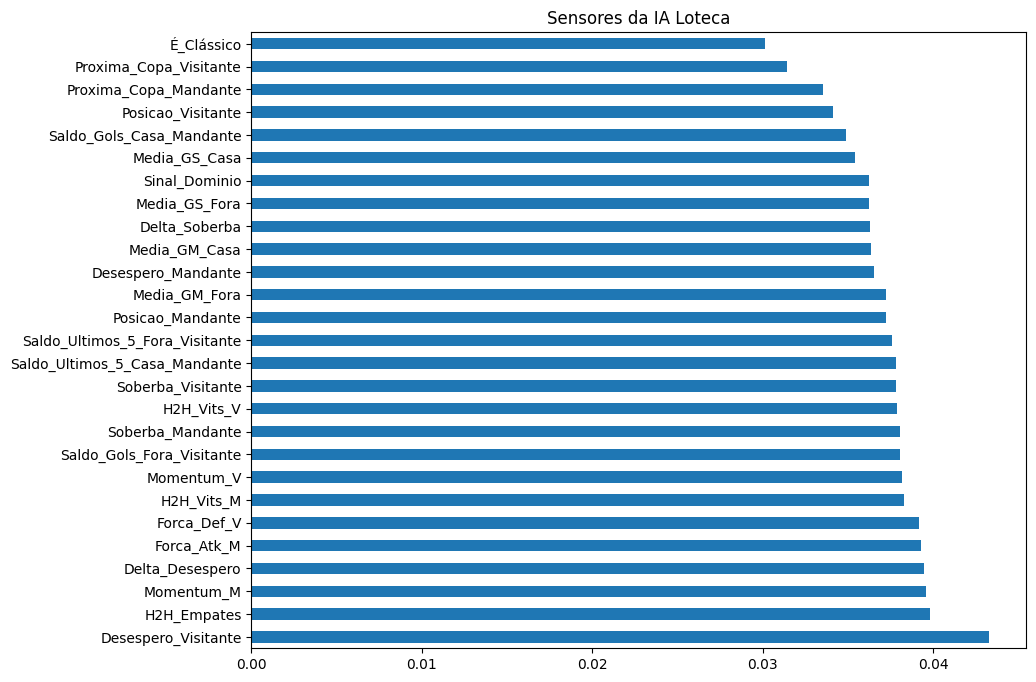

In [ ]:
import matplotlib.pyplot as plt

# Mostra quais sensores a IA mais usou para chegar nos 14 pontos
plt.figure(figsize=(10, 8))
importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.nlargest(33).plot(kind='barh')
plt.title("Sensores da IA Loteca")
plt.show()